In [78]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, GRU, Bidirectional, LSTM
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error
import keras

In [79]:
# Read data from csv file, consider column 'date' as index and parse it into date object
dataset = pd.read_csv('historical_stock_prices.csv', index_col='date', parse_dates=['date'])

In [80]:
# Selecting training_set from begining of 2015 till end of 2017, we can do this because our index in date object
# and selecting test_set from begining of 2018 onwards
trainSet = dataset['2015':'2017'].sort_values(by=['ticker','date'])
testSet = dataset['2018':].sort_values(by=['ticker','date'])

# Transforming each stocks independently #

In [81]:
symbols = trainSet.ticker.unique()

In [159]:
scaler = {}
train_set = {}
test_set = {}
for s in symbols:

    train_set[s] = {}
    test_set[s] = {}
    x_train = []
    y_train = []
    x_test = []
    y_test = []
    
    sc = MinMaxScaler(feature_range=(0,1))
    train_stock = trainSet.loc[trainSet['ticker'] == s][['adj_close']].values
    test_stock = testSet.loc[testSet['ticker'] == s][['adj_close']].values
    
    
    sc.partial_fit(train_stock)
    sc.partial_fit(test_stock)
    
    train_scaled = sc.transform(train_stock)
    test_scaled = sc.transform(test_stock)
    scaler[s] = sc
    
    for i in range(timesteps, len(train_scaled)):
        x_train.append(train_scaled[i-timesteps: i, 0])
        y_train.append(train_scaled[i,0])
        
    X_train, Y_train = np.array(x_train), np.array(y_train)
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    
    train_set[s]['X'] = X_train
    train_set[s]['Y'] = Y_train
    
    for i in range(timesteps, len(test_scaled)):
        x_test.append(test_scaled[i-timesteps: i, 0])
        y_test.append(test_scaled[i,0])
    X_test, Y_test = np.array(x_test), np.array(y_test)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
    
    test_set[s]['X'] = X_test
    test_set[s]['Y'] = Y_test

    if s== 'AAPL':
        break

In [83]:
train_set.keys(), test_set.keys()

(dict_keys(['A', 'AA', 'AABA', 'AAL', 'AAME', 'AAN', 'AAOI', 'AAON', 'AAP', 'AAPL']),
 dict_keys(['A', 'AA', 'AABA', 'AAL', 'AAME', 'AAN', 'AAOI', 'AAON', 'AAP', 'AAPL']))

In [84]:
# Callback function `earlystopping` to trigger while training it monitor 'loss'
# start from first epoch it record min value of loss and if model can not find 
# lower loss value in next 3 epochs model will stop training.
es = keras.callbacks.EarlyStopping(monitor='val_loss',patience=3, mode='min')

## Perform experiment  on data transformed independently ##

In [162]:
# The GRU architecture
# We are using Sequential model of Keras
# Our hidden layer using activation = 'tanh' and having 50 neurons each layer
# The output layer of fully connected layer is having only 1 neurons because we want only one output value

regressorGRU = Sequential()
# First GRU layer with Dropout regularisation
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(60,1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Second GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(60,1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Third GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(60,1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Fourth GRU layer
regressorGRU.add(GRU(units=50, activation='tanh'))
regressorGRU.add(Dropout(0.2))
# The output layer
regressorGRU.add(Dense(units=1))

In [163]:
# Compiling the model
regressorGRU.compile(optimizer='rmsprop', loss='mean_squared_error')

In [164]:
n_epoch = 10
X_train = train_set['AAPL']['X']
Y_train = train_set['AAPL']['Y']
regressorGRU.fit(X_train, 
              Y_train,
              epochs = n_epoch, 
              batch_size = len(Y_train) // n_epoch)

Epoch 1/10
695/695 [==============================] - 8s 11ms/step - loss: 0.0215
Epoch 2/10
695/695 [==============================] - 4s 5ms/step - loss: 0.0054
Epoch 3/10
695/695 [==============================] - 4s 5ms/step - loss: 0.0043
Epoch 4/10
695/695 [==============================] - 4s 5ms/step - loss: 0.0052
Epoch 5/10
695/695 [==============================] - 4s 5ms/step - loss: 0.0039
Epoch 6/10
695/695 [==============================] - 4s 5ms/step - loss: 0.0027
Epoch 7/10
695/695 [==============================] - 4s 5ms/step - loss: 0.0049
Epoch 8/10
695/695 [==============================] - 4s 5ms/step - loss: 0.0035
Epoch 9/10
695/695 [==============================] - 4s 5ms/step - loss: 0.0039
Epoch 10/10
695/695 [==============================] - 4s 5ms/step - loss: 0.0030


In [ ]:
# Save model
# regressorGRU.save('gru_adj_close_price_prediction_v1.h5')

## Helper function ##

In [165]:
# Calculate Mean squared_error #
def return_mse(test,predicted):
    mse = mean_squared_error(test, predicted)
    print("The mean squared error is {}.".format(mse))

In [166]:
# Plotting graph
def plotting_graph(y_test, y_pred, ticker, des):
    plt.plot(y_test, color='green', label='Actual adj_close value')
    plt.plot(y_pred, color='red', label='Predicted adj_close value')
    plt.title('Prediction of {} on {}'.format(ticker, des))
    plt.xlabel('Time steps')
    plt.ylabel('adj_close value')
    plt.legend()
    plt.show()

In [167]:
def predicting_results(data, s, des):
    X_test = data[s]['X']
    Y_test = data[s]['Y']
    # Inverse transform Y_test
    Y_test = Y_test.reshape(-1,1)
    Y_true = scaler[s].inverse_transform(Y_test)
    # Predicting
    result = regressorGRU.predict(X_test)
    y_pred = scaler[s].inverse_transform(result)
    # Evaluate result
    plotting_graph(Y_true,y_pred, s, des)
    print(return_mse(Y_true,y_pred))

### Predicting on Test set ###

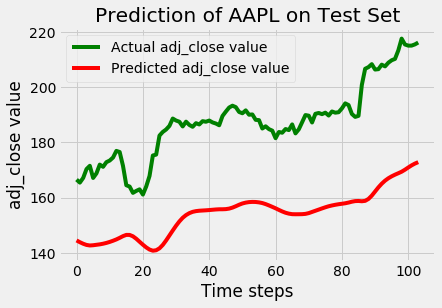

The mean squared error is 1143.7662147254327.
None


In [168]:
predicting_results(test_set, 'AAPL', 'Test Set')

### Predicting on training_set ###

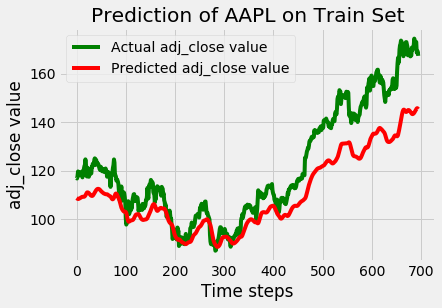

The mean squared error is 176.91565427055087.
None


In [169]:
predicting_results(train_set, 'AAPL', 'Train Set')

# Transforming all stock data at once #

In [219]:
test_set_1 = testSet.loc[testSet['ticker'] == 'AAPL'][['adj_close']].values
train_set_1 = trainSet[['adj_close']].values

In [220]:
sc = MinMaxScaler(feature_range=(0,1))
sc.partial_fit(test_set_1)
sc.partial_fit(train_set_1)

train_set_scaled = sc.transform(train_set_1)
test_set_scaled = sc.transform(test_set_1)

In [221]:
# Count entries of each stock
tickers_entry = trainSet.groupby(['ticker'])['adj_close'].count()
len(tickers_entry)

5493

In [222]:
# Define x_train y_train
timesteps = 60
train_set_all_stocks = []
s = 0
k = 0
for entries in tickers_entry:
    x_train = []
    y_train = []
    j = 0
    for i in range(timesteps, entries):
        x_train.append(train_set_scaled[s+j:s+i,0])
        y_train.append(train_set_scaled[s+i,0])
        j += 1
    if len(x_train) != 0:
        X_train, Y_train = np.array(x_train), np.array(y_train)
        X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
        train_set_all_stocks.append([X_train,Y_train])
    s += entries
    k += 1
    if k == 10:
        break

### Checking our X and Y being prepared proper or not ###

In [223]:
# Original values
aapl_stock = trainSet.loc[trainSet['ticker'] == 'AAPL'][['adj_close']].values
aapl_x = []
aapl_y = []
for i in range(timesteps, len(aapl_stock)):
    aapl_x.append(aapl_stock[i-timesteps: i, 0])
    aapl_y.append(aapl_stock[i,0])
x, y = np.array(aapl_x), np.array(aapl_y)
y.sum()

84264.98104095458

In [224]:
tickers_entry[:10]

ticker
A       755
AA      754
AABA    755
AAL     755
AAME    696
AAN     755
AAOI    755
AAON    755
AAP     755
AAPL    755
Name: adj_close, dtype: int64

In [201]:
# train_set_all_stocks which transformed all at once
# index 9 is match to AAPL stock data
y1 = train_set_all_stocks[9][1]
y1 = y1.reshape(-1,1)
y1 = sc.inverse_transform(y1)
y1.sum()

84264.98104095458

In [225]:
# train_set which transformed each stocks independently
y0 = train_set['AAPL']['Y']
y0 = y0.reshape(-1,1)
y0 = scaler['AAPL'].inverse_transform(y0)
y0.sum()

84264.98104095458

The above calculation give us same result 84264.98104095458, so our train_set_all_stocks (transformed all stocks at once) and train_set (transformed each stock independently) are prepared properly

## Perform experiment on data which transformed all at once ##

In [230]:
regressor = Sequential()
# First GRU layer with Dropout regularisation
regressor.add(GRU(units=50, return_sequences=True, input_shape=(60,1), activation='tanh'))
regressor.add(Dropout(0.2))
# Second GRU layer
regressor.add(GRU(units=50, return_sequences=True, input_shape=(60,1), activation='tanh'))
regressor.add(Dropout(0.2))
# Third GRU layer
regressor.add(GRU(units=50, return_sequences=True, input_shape=(60,1), activation='tanh'))
regressor.add(Dropout(0.2))
# Fourth GRU layer
regressor.add(GRU(units=50, activation='tanh'))
regressor.add(Dropout(0.2))
# The output layer
regressor.add(Dense(units=1))

In [231]:
regressor.compile(optimizer='rmsprop', loss='mean_squared_error')

In [232]:
n_epoch = 10
X_train = train_set_all_stocks[9][0]
Y_train = train_set_all_stocks[9][1]
regressor.fit(X_train, 
              Y_train,
              epochs = n_epoch, 
              batch_size = len(Y_train) // n_epoch)

Epoch 1/10
695/695 [==============================] - 9s 14ms/step - loss: 4.2992e-04
Epoch 2/10
695/695 [==============================] - 4s 5ms/step - loss: 6.9364e-08
Epoch 3/10
695/695 [==============================] - 4s 5ms/step - loss: 4.1320e-05
Epoch 4/10
695/695 [==============================] - 4s 5ms/step - loss: 1.7007e-05
Epoch 5/10
695/695 [==============================] - 4s 5ms/step - loss: 4.1363e-05
Epoch 6/10
695/695 [==============================] - 4s 5ms/step - loss: 3.0632e-05
Epoch 7/10
695/695 [==============================] - 4s 5ms/step - loss: 1.0594e-05
Epoch 8/10
695/695 [==============================] - 4s 5ms/step - loss: 2.5435e-05
Epoch 9/10
695/695 [==============================] - 4s 5ms/step - loss: 1.4022e-05
Epoch 10/10
695/695 [==============================] - 4s 5ms/step - loss: 1.5124e-05


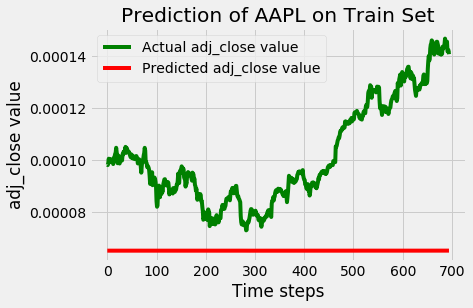

In [234]:
X_test = train_set_all_stocks[9][0]
Y_test = train_set_all_stocks[9][1]

# Predicting
result = regressor.predict(X_test)

# Plotting result
plotting_graph(Y_test,result, 'AAPL', 'Train Set')